In [1]:
#@title Load Data from Dropbox
!wget -O data_input.csv https://www.dropbox.com/s/g9xvk71iio3rcmu/single_input?dl=0
!wget -O data_output.csv https://www.dropbox.com/s/szkgat2th6x92mu/single_output?dl=0

Will not apply HSTS. The HSTS database must be a regular and non-world-writable file.
ERROR: could not open HSTS store at '/home/anovak/.wget-hsts'. HSTS will be disabled.
--2020-08-19 13:40:23--  https://www.dropbox.com/s/g9xvk71iio3rcmu/single_input?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 2620:100:6022:1::a27d:4201, 162.125.66.1
Connecting to www.dropbox.com (www.dropbox.com)|2620:100:6022:1::a27d:4201|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/g9xvk71iio3rcmu/single_input [following]
--2020-08-19 13:40:23--  https://www.dropbox.com/s/raw/g9xvk71iio3rcmu/single_input
Reusing existing connection to [www.dropbox.com]:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc21b12d3dd4d454dcf9c6ccea06.dl.dropboxusercontent.com/cd/0/inline/A9wLIDl2DbzYhQh61RUR7r6xQQMzlKQk-yj9BtLW5bCSbRvVe9c-zu0o7LFMjK9YryzqtbXXrF2EkbzmJSU54mnWa8J24DV6PQjD-7Xo-ZcCnJYjJ89dtDMGP17L2zpyofY/file# [following]
--2020-08-19 13:40

In [4]:
#@title Import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import backend
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import optimizers
from scipy.signal import argrelextrema as ext
import tensorflow as tf

In [5]:
#@title Reading Data
dfi = pd.read_csv('data_input.csv')
dfi[:6]
dfo = pd.read_csv('data_output.csv')
dfo[:6]

,2.28e10,2.28025e10,2.2805e10,2.28075e10,2.281e10,2.28125e10,2.2815e10,2.28175e10,2.282e10,2.28225e10,...,2.29275e10,2.293e10,2.29325e10,2.2935e10,2.29375e10,2.294e10,2.29425e10,2.2945e10,2.29475e10,2.295e10
0,112.837188,109.988434,106.134855,101.076908,94.595033,86.460540,76.460702,64.451038,50.459696,34.892642,...,2530.836075,2261.083019,2029.781670,1830.394376,1657.627710,1507.180224,1375.541747,1259.834608,1157.688320,1067.140633
1,327.283486,339.060828,351.193185,363.545106,375.922717,388.052728,399.554484,409.903165,418.382082,424.022760,...,1629.599444,1471.268993,1334.888690,1216.619880,1113.420476,1022.856042,942.960802,872.134130,809.062601,752.660679
2,47.039006,40.060751,32.127870,23.435324,14.465403,6.227775,0.699967,1.652486,16.234075,58.107446,...,2257.272207,2032.000113,1836.923530,1667.201025,1518.861950,1388.639366,1273.835289,1172.212551,1081.908236,1001.364368
3,116.786545,114.717253,112.104138,108.819025,104.716629,99.634186,93.393477,85.807612,76.696807,65.921221,...,4498.524795,3959.173068,3498.341474,3104.151169,2766.182138,2475.516958,2224.636420,2007.254689,1818.140876,1652.949917
4,220.516834,226.546225,232.489322,238.201355,243.491296,248.107634,251.720212,253.897440,254.078560,251.541912,...,2060.598038,1834.649833,1643.469088,1480.392441,1340.255310,1219.010444,1113.453625,1021.023890,939.656282,867.672070
5,128.795965,127.732945,126.113414,123.797188,120.620988,116.396137,110.907862,103.918232,95.176376,84.443097,...,3707.185479,3264.673360,2890.117731,2571.584623,2299.344339,2065.488785,1863.592204,1688.425078,1535.719551,1401.980104


In [175]:
#@title Storing data in arrays, shuffle and split
X = dfi.to_numpy()[:,:-1]
y = dfo.to_numpy()
freqs = dfo.columns.to_numpy().astype(float)

# from sklearn.utils import shuffle
# X, y = shuffle(X, y, random_state=0)

# Need to do this because shufflinf would scramble the order for 1 point predictions
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.90, shuffle=False)

In [176]:
#@title Reshape to predict single point
def flatten(Xs, ys):
    SIZE = ys.shape[0]
    NPTS = ys.shape[-1]
    fXs = np.empty((SIZE*NPTS, Xs.shape[-1]+1))
    for i in range(SIZE):
        fXs[i*NPTS:(i+1)*NPTS, :-1] = np.tile(Xs[i], (NPTS,1))
        fXs[i*NPTS:(i+1)*NPTS, -1] = freqs#np.arange(NPTS)
        
    fys = np.empty((SIZE*NPTS, 2))
    for i in range(SIZE):
        fys[i*NPTS:(i+1)*NPTS, 0] = freqs#np.arange(NPTS)
        fys[i*NPTS:(i+1)*NPTS, 1] = ys[i]
        
    return fXs, fys

Xf_train, yf_train = flatten(X_train, y_train)
Xf_test, yf_test = flatten(X_test, y_test)

In [177]:
#@title Transform
from sklearn.preprocessing import QuantileTransformer
scalerX = QuantileTransformer()
scalerY = QuantileTransformer()
Xs_train = scalerX.fit_transform(Xf_train) 
ys_train = scalerY.fit_transform(yf_train) 

Xs_test = scalerX.transform(Xf_test) 
ys_test = scalerY.transform(yf_test) 

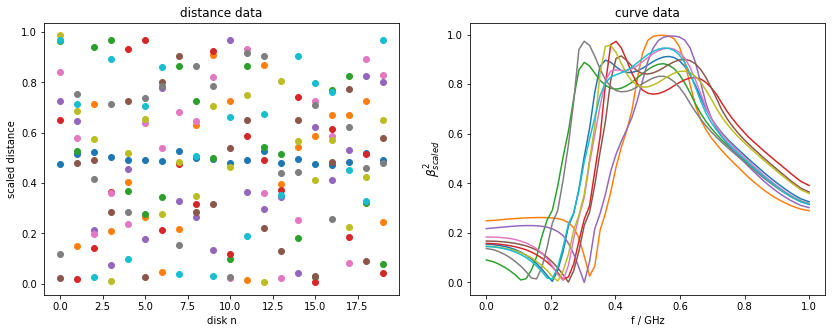

In [157]:
#@title Plot transformed
fig, axs = plt.subplots(1, 2, figsize=(14,5)) 

for i in range(min(10, len(y))):    
    yax = Xs_train[i*61:i*61+61][0][:-1]
    xax = range(len(yax))
    axs[0].scatter(xax, yax, label=i)
    axs[0].set_xlabel("disk n")
    axs[0].set_ylabel("scaled distance")
        
    xax = ys_train[i*61:i*61+61][:, :-1].T[0]
    yax = ys_train[i*61:i*61+61][:, -1:].T[0]
    axs[1].plot(xax, yax, label=i)
    axs[1].set_xlabel("f / GHz")
    axs[1].set_ylabel(r"$\beta^2_{scaled}$",fontsize=12)

axs[0].set_title("distance data")
axs[1].set_title("curve data");

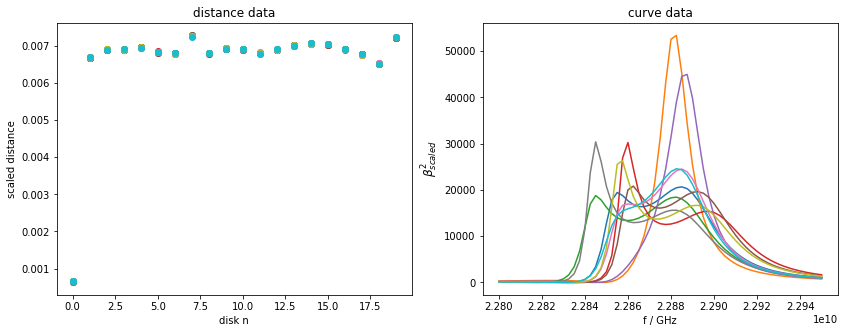

In [161]:
#@title Plot inverse transform roundtrip
fig, axs = plt.subplots(1, 2, figsize=(14,5)) 
Xsi = scalerX.inverse_transform(Xs_train)
ysi = scalerY.inverse_transform(ys_train)

for i in range(min(10, len(y))):    
    yax = Xsi[i*61:i*61+61][0][:-1]
    xax = range(len(yax))
    axs[0].scatter(xax, yax, label=i)
    axs[0].set_xlabel("disk n")
    axs[0].set_ylabel("scaled distance")
        
    xax = ysi[i*61:i*61+61][:, :-1].T[0] 
    yax = ysi[i*61:i*61+61][:, -1:].T[0]
    axs[1].plot(xax, yax, label=i)
    axs[1].set_xlabel("f / GHz")
    axs[1].set_ylabel(r"$\beta^2_{scaled}$",fontsize=12)

axs[0].set_title("distance data")
axs[1].set_title("curve data");

In [162]:
#@title Splitting into test and train data
print(Xs.shape, ys.shape)

(602009, 21) (602009, 2)


In [164]:
#@title Actual training
model = Sequential()
model.add(Dense(500, input_dim=21, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2, activation='linear'))


model.compile(optimizer = "adam", loss ='mse', metrics=['accuracy','mse'])

history=model.fit(Xs_train, ys_train, epochs=10, verbose=1,validation_split=0.2)

Train on 48116 samples, validate on 12030 samples
Epoch 1/10
48116/48116 [==============================] - 7s 151us/sample - loss: 0.0164 - accuracy: 0.8155 - mse: 0.0164 - val_loss: 0.0052 - val_accuracy: 0.9101 - val_mse: 0.0052
Epoch 2/10
48116/48116 [==============================] - 8s 168us/sample - loss: 0.0058 - accuracy: 0.9079 - mse: 0.0058 - val_loss: 0.0032 - val_accuracy: 0.9373 - val_mse: 0.0032
Epoch 3/10
48116/48116 [==============================] - 8s 174us/sample - loss: 0.0041 - accuracy: 0.9234 - mse: 0.0041 - val_loss: 0.0015 - val_accuracy: 0.9524 - val_mse: 0.0015
Epoch 4/10
48116/48116 [==============================] - 9s 194us/sample - loss: 0.0032 - accuracy: 0.9338 - mse: 0.0032 - val_loss: 0.0011 - val_accuracy: 0.9612 - val_mse: 0.0011
Epoch 5/10
48116/48116 [==============================] - 9s 194us/sample - loss: 0.0027 - accuracy: 0.9400 - mse: 0.0027 - val_loss: 0.0011 - val_accuracy: 0.9529 - val_mse: 0.0011
Epoch 6/10
48116/48116 [================

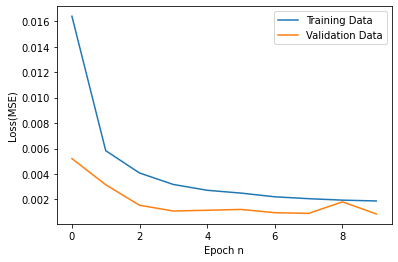

In [165]:
#@title Plot loss
plt.plot(history.history['mse'],label='Training Data')
plt.plot(history.history['val_mse'],label='Validation Data')
plt.xlabel("Epoch n")
plt.ylabel("Loss(MSE)")
plt.legend()

In [217]:
predictions = model.predict(Xs_test)

In [218]:
predi = scalerY.inverse_transform(predictions)
predi_truth = scalerY.inverse_transform(ys_test)

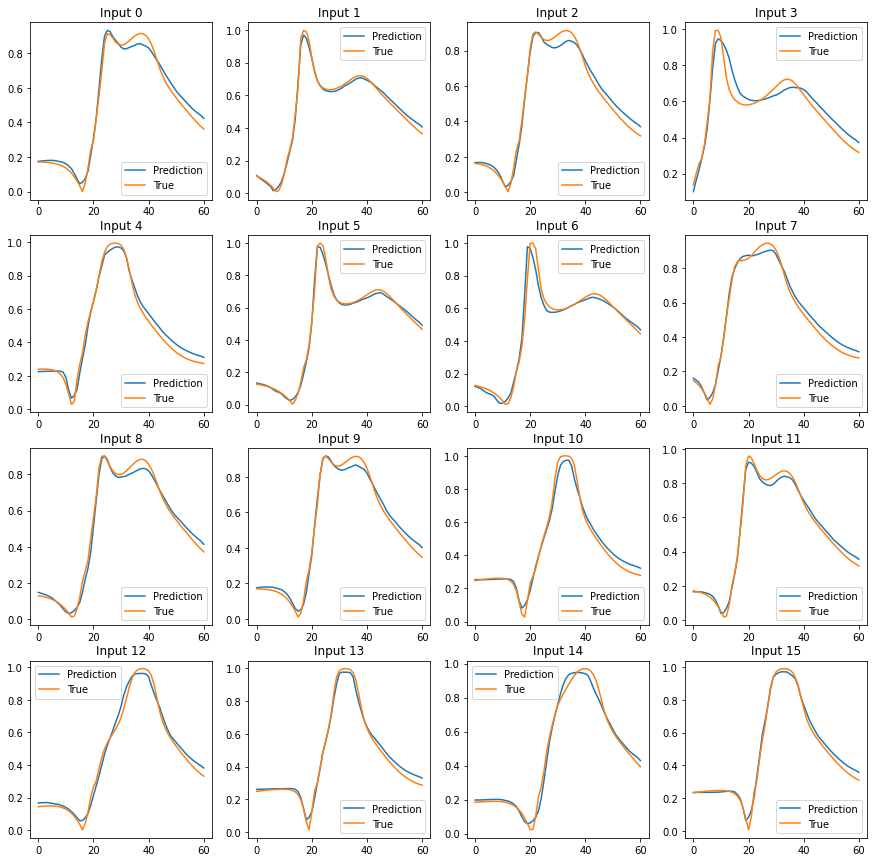

In [219]:
#@title Plot evaluation examples
fig, axs = plt.subplots(4, 4, figsize=(15,15))
axs = axs.flatten()
for i, ax in enumerate(axs):
    ax.plot(range(61), predictions[i*61:i*61+61][:, 1], label="Prediction")
    ax.plot(range(61), ys_test[i*61:i*61+61][:, 1], label="True")
    ax.legend()
    ax.set_title(f"Input {i}")

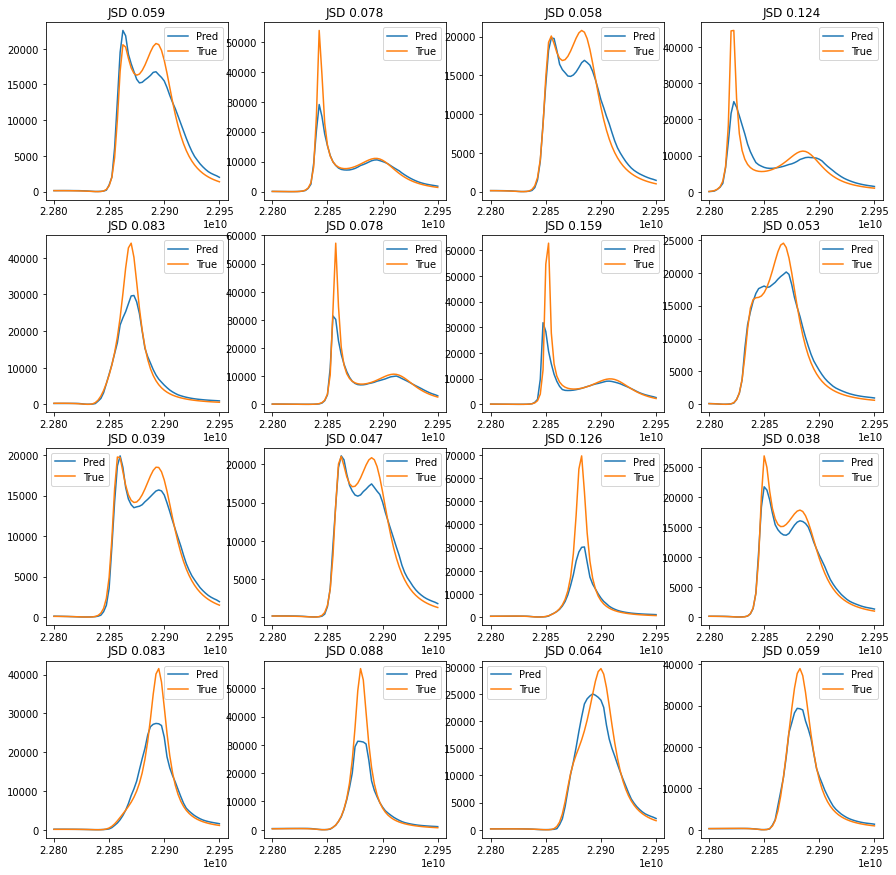

In [220]:
#@title Plot evaluation examples
from scipy.spatial.distance import jensenshannon as jsd

fig, axs = plt.subplots(4, 4, figsize=(15,15))
axs = axs.flatten()
_size = 61
for i, ax in enumerate(axs):
    xar = predi_truth[i*61:i*61+61][:, :-1].T[0]
    _pred = predi[i*61:i*61+61][:, 1]
    _tru = predi_truth[i*61:i*61+61][:, 1]
    ax.plot(xar, _pred, label="Pred")
    ax.plot(xar, _tru, label="True")
    ax.legend()
    ax.set_title(f"JSD {round(jsd(_tru, _pred),3)}")

## Let's try predicting at shifted points

In [237]:
A = Xf_test.copy()
SHIFT = 5e7 # Shift in MHz
A[:, -1] = A[:, -1] + SHIFT

As = scalerX.transform(A) 

In [238]:
As_pred = model.predict(As)
As_predi = scalerY.inverse_transform(As_pred)

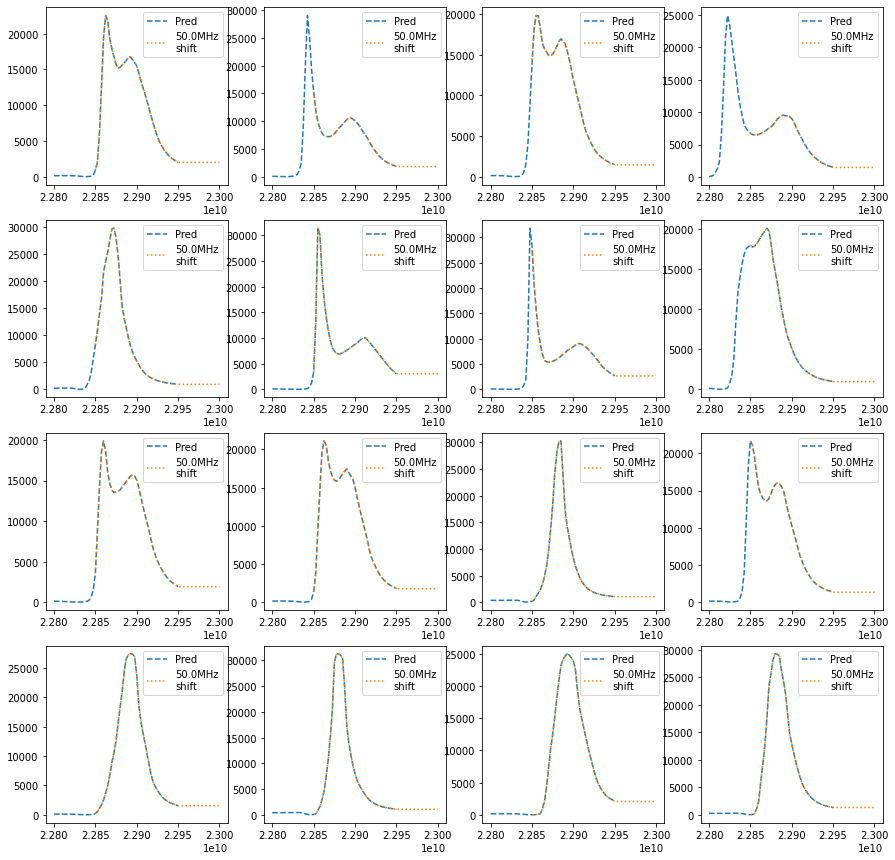

In [242]:
#@title Plot evaluation examples
from scipy.spatial.distance import jensenshannon as jsd

fig, axs = plt.subplots(4, 4, figsize=(15,15))
axs = axs.flatten()
_size = 61
for i, ax in enumerate(axs):
    xar = predi_truth[i*61:i*61+61][:, :-1].T[0]
    _pred = predi[i*61:i*61+61][:, 1]
    _shift = As_predi[i*61:i*61+61][:, 1]
    ax.plot(xar, _pred, label="Pred", ls='--')
    ax.plot(xar + SHIFT, _shift, label=f"{SHIFT/1e6}MHz\nshift", ls=':')
    ax.legend()
    #ax.set_title(f"JSD {round(jsd(_shift, _pred),3)}")